In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Physical and simulation parameters
Lx, Ly = 1.0, 1.0       # Domain size
c = 1.0                 # Wave speed
Nx, Ny = 50, 50         # Grid resolution
dx, dy = Lx/Nx, Ly/Ny
x = np.linspace(0, Lx, Nx+1)
y = np.linspace(0, Ly, Ny+1)
X, Y = np.meshgrid(x, y, indexing='ij')

# Time stepping
T = 2.0                 # Final time
CFL = 0.4               # CFL condition
dt = CFL * min(dx, dy) / c
Nt = int(T/dt)
print(f"Using dt = {dt:.5f}, total time steps: {Nt}")

Using dt = 0.00800, total time steps: 250


In [ ]:
def initial_conditions(m=1, n=1):
    """Initial displacement and velocity for mode (m,n)."""
    u0 = np.sin(m * np.pi * X / Lx) * np.sin(n * np.pi * Y / Ly)
    v0 = np.zeros_like(u0)  # Zero initial velocity
    return u0, v0

def exact_solution(t, m=1, n=1):
    """Exact solution using separation of variables."""
    omega_mn = c * np.pi * np.sqrt((m / Lx)**2 + (n / Ly)**2)
    return np.sin(m * np.pi * X / Lx) * np.sin(n * np.pi * Y / Ly) * np.cos(omega_mn * t)

In [ ]:
def laplacian(u):
    """Apply 2D central difference Laplacian with Dirichlet BCs."""
    u_xx = (np.roll(u, -1, axis=0) - 2*u + np.roll(u, 1, axis=0)) / dx**2
    u_yy = (np.roll(u, -1, axis=1) - 2*u + np.roll(u, 1, axis=1)) / dy**2
    # Dirichlet BC: enforce zero at boundaries
    u_xx[0, :] = u_xx[-1, :] = 0
    u_yy[:, 0] = u_yy[:, -1] = 0
    return u_xx + u_yy

In [ ]:
def rk4_step(u, v, dt):
    """RK4 method for the second-order wave equation u_tt = c^2 * Laplacian(u)."""
    def f1(v): return v
    def f2(u): return c**2 * laplacian(u)

    k1_u = f1(v)
    k1_v = f2(u)

    k2_u = f1(v + 0.5 * dt * k1_v)
    k2_v = f2(u + 0.5 * dt * k1_u)

    k3_u = f1(v + 0.5 * dt * k2_v)
    k3_v = f2(u + 0.5 * dt * k2_u)

    k4_u = f1(v + dt * k3_v)
    k4_v = f2(u + dt * k3_u)

    u_new = u + dt/6 * (k1_u + 2*k2_u + 2*k3_u + k4_u)
    v_new = v + dt/6 * (k1_v + 2*k2_v + 2*k3_v + k4_v)
    return u_new, v_new

In [ ]:
def compute_energy(u, v, dx, dy, c):
    kinetic = 0.5 * np.sum(v**2) * dx * dy
    du_dx = (np.roll(u, -1, axis=0) - np.roll(u, 1, axis=0)) / (2*dx)
    du_dy = (np.roll(u, -1, axis=1) - np.roll(u, 1, axis=1)) / (2*dy)
    du_dx[0, :], du_dx[-1, :] = 0, 0
    du_dy[:, 0], du_dy[:, -1] = 0, 0
    potential = 0.5 * c**2 * np.sum(du_dx**2 + du_dy**2) * dx * dy
    return kinetic, potential, kinetic + potential


In [ ]:
def solve_wave_eq(plot_times, m=1, n=1):
    times = []
    kinetic_vals, potential_vals, total_energy_vals = [], [], []
    tracked_mode = (m, n)  # same as input mode
    mode_amps = []
    fft_times = []


    u, v = initial_conditions(m, n)
    t = 0.0
    results = {0.0: (u.copy(), exact_solution(0.0, m, n))}

    # Initialize energy tracking
    times = []
    kinetic_vals, potential_vals, total_energy_vals = [], [], []

    for step in range(1, Nt + 1):
        u, v = rk4_step(u, v, dt)
        t += dt

        if step % 2 == 0:  # every 10 steps to reduce data volume
          u_hat = np.fft.fft2(u) / (Nx * Ny)
          amp = np.abs(u_hat[m, n])  # track mode (m,n)
          mode_amps.append(amp)
          fft_times.append(t)


        # Energy tracking
        k, p, tot = compute_energy(u, v, dx, dy, c)
        kinetic_vals.append(k)
        potential_vals.append(p)
        total_energy_vals.append(tot)
        times.append(t)

        if np.any(np.isclose(t, plot_times, atol=dt / 2)):
            results[round(t, 3)] = (u.copy(), exact_solution(t, m, n))

    # Plot numerical vs exact surfaces (same as before)
    fig = plt.figure(figsize=(5 * len(plot_times), 8))
    for i, t_val in enumerate(plot_times):
        u_num, u_exact = results[round(t_val, 3)]

        ax1 = fig.add_subplot(2, len(plot_times), i + 1, projection='3d')
        ax1.plot_surface(X, Y, u_num, cmap=cm.viridis)
        ax1.set_title(f'Numerical u(x,y,{t_val:.1f})')
        ax1.set_zlim(-1, 1)

        ax2 = fig.add_subplot(2, len(plot_times), i + 1 + len(plot_times), projection='3d')
        ax2.plot_surface(X, Y, u_exact, cmap=cm.coolwarm)
        ax2.set_title(f'Exact u(x,y,{t_val:.1f})')
        ax2.set_zlim(-1, 1)

    plt.suptitle(f'2D Wave Equation, Mode ({m},{n})', fontsize=16)
    plt.tight_layout()
    plt.show()

    return times, kinetic_vals, potential_vals, total_energy_vals, fft_times, mode_amps



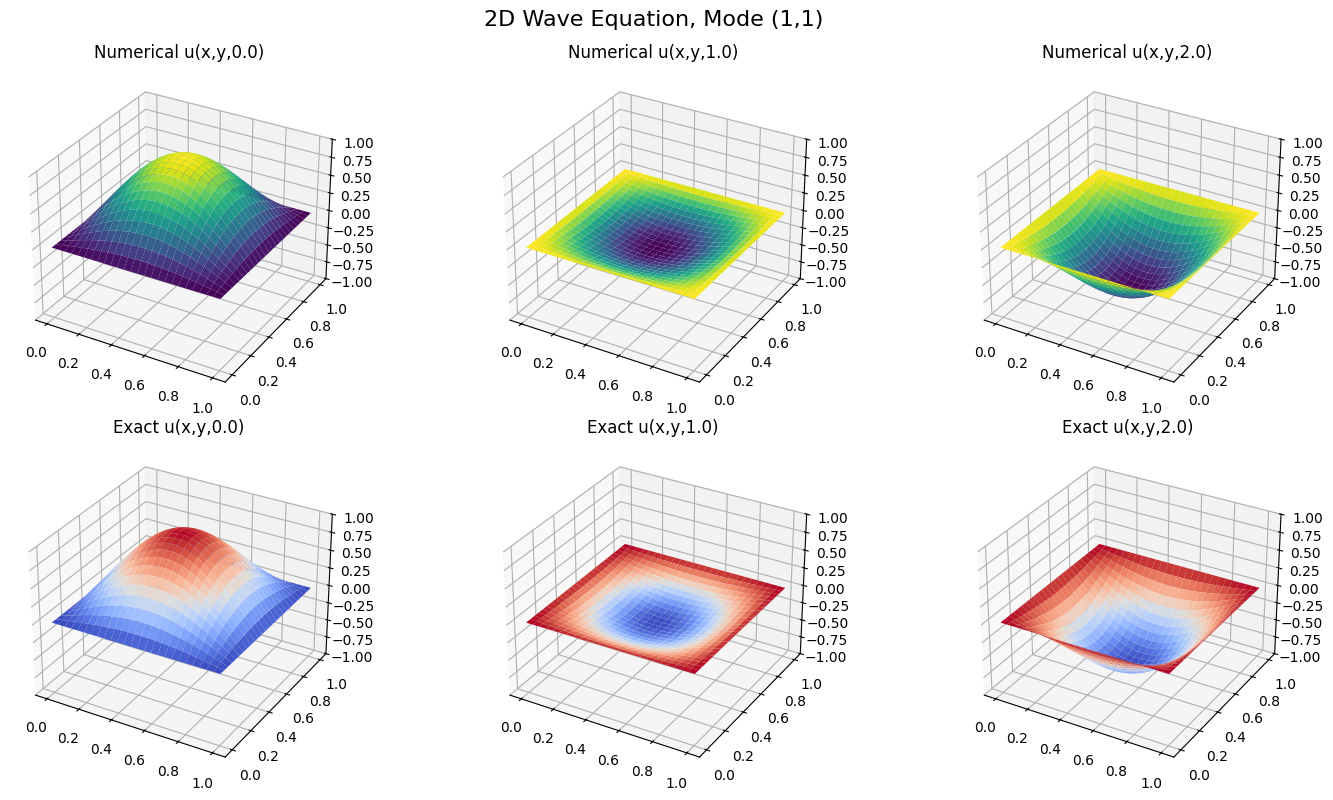

In [ ]:
times1, ke1, pe1, te1, fft_t1, amps1 = solve_wave_eq(plot_times=[0.0, 1.0, 2.0], m=1, n=1)


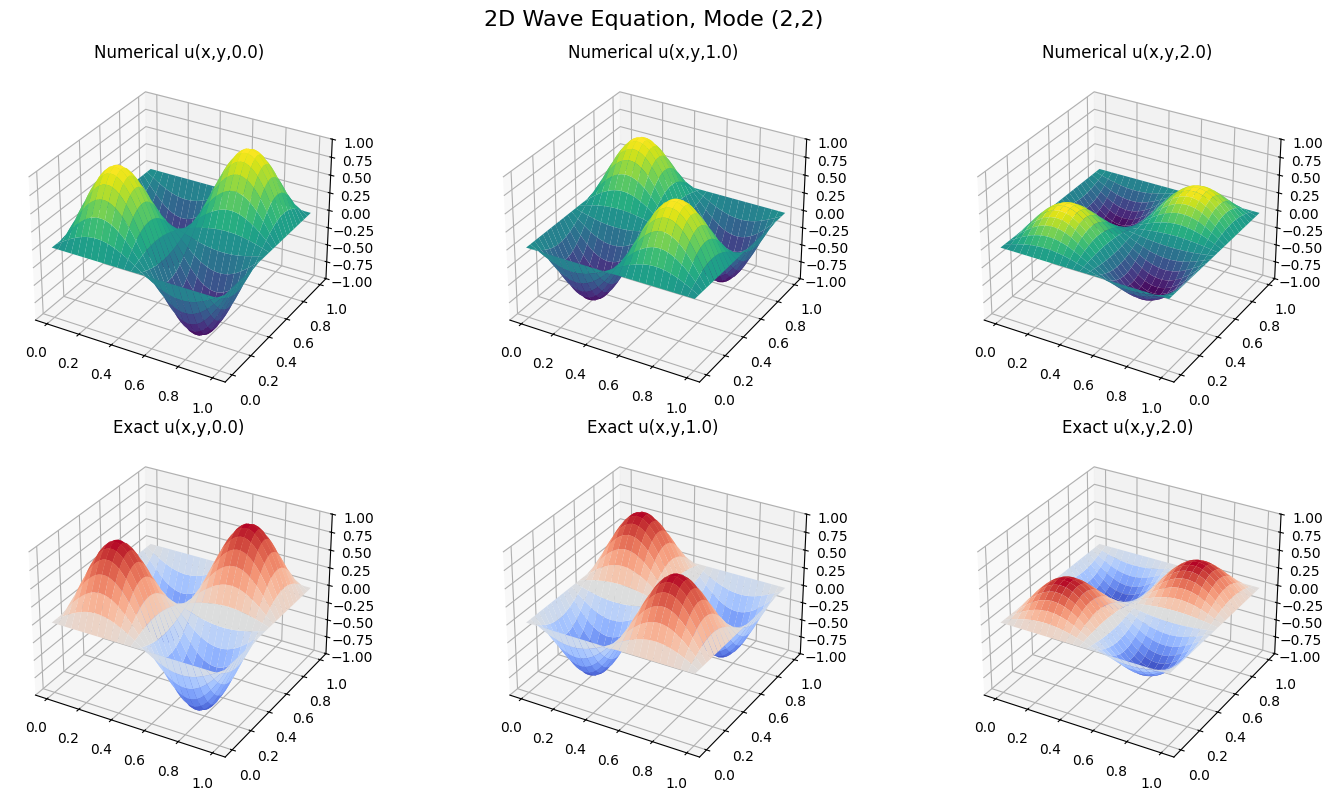

In [ ]:
times2, ke2, pe2, te2, fft_t2, amps2 = solve_wave_eq(plot_times=[0.0, 1.0, 2.0], m=2, n=2)

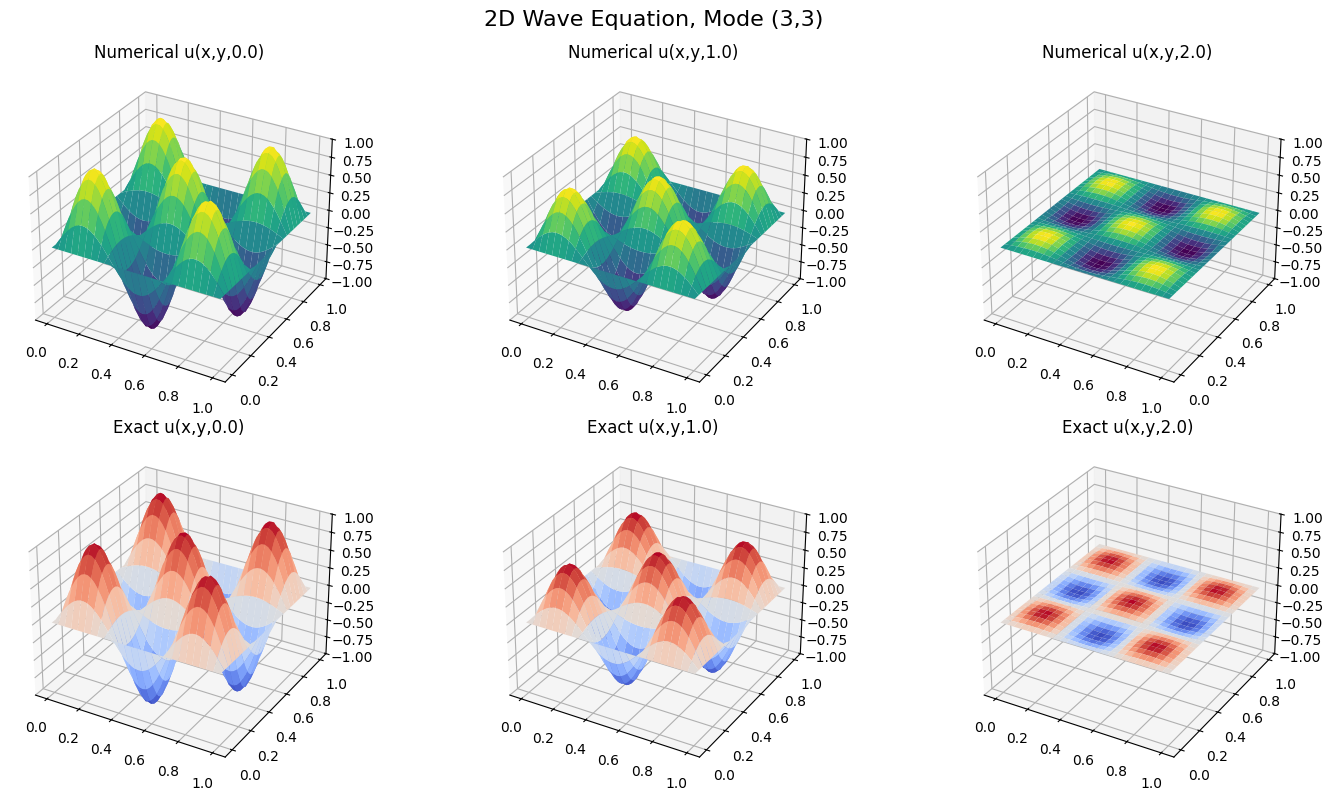

In [ ]:
times3, ke3, pe3, te3, fft_t3, amps3 = solve_wave_eq(plot_times=[0.0, 1.0, 2.0], m=3, n=3)

In [ ]:
def spatial_convergence_study(m=1, n=1, T=2.0):
    Nx_list = [10, 20, 40, 80]
    errors = []
    dx_vals = []

    for Nx in Nx_list:
        Ny = Nx
        Lx = Ly = 1.0
        dx = Lx / Nx
        dy = Ly / Ny
        x = np.linspace(0, Lx, Nx+1)
        y = np.linspace(0, Ly, Ny+1)
        Xg, Yg = np.meshgrid(x, y, indexing='ij')

        dt = CFL * min(dx, dy)
        Nt = int(T / dt)
        dt = T / Nt  # readjust dt to hit T exactly

        def laplacian_local(u):
            u_xx = (np.roll(u, -1, axis=0) - 2*u + np.roll(u, 1, axis=0)) / dx**2
            u_yy = (np.roll(u, -1, axis=1) - 2*u + np.roll(u, 1, axis=1)) / dy**2
            u_xx[0, :] = u_xx[-1, :] = 0
            u_yy[:, 0] = u_yy[:, -1] = 0
            return u_xx + u_yy

        def rk4_local(u, v, dt):
            def f1(v): return v
            def f2(u): return c**2 * laplacian_local(u)

            k1_u = f1(v)
            k1_v = f2(u)
            k2_u = f1(v + 0.5 * dt * k1_v)
            k2_v = f2(u + 0.5 * dt * k1_u)
            k3_u = f1(v + 0.5 * dt * k2_v)
            k3_v = f2(u + 0.5 * dt * k2_u)
            k4_u = f1(v + dt * k3_v)
            k4_v = f2(u + dt * k3_u)
            u_new = u + dt/6 * (k1_u + 2*k2_u + 2*k3_u + k4_u)
            v_new = v + dt/6 * (k1_v + 2*k2_v + 2*k3_v + k4_v)
            return u_new, v_new

        # Initial conditions
        u = np.sin(m * np.pi * Xg / Lx) * np.sin(n * np.pi * Yg / Ly)
        v = np.zeros_like(u)

        for _ in range(Nt):
            u, v = rk4_local(u, v, dt)

        omega_mn = c * np.pi * np.sqrt((m/Lx)**2 + (n/Ly)**2)
        u_exact = np.sin(m * np.pi * Xg / Lx) * np.sin(n * np.pi * Yg / Ly) * np.cos(omega_mn * T)

        error = np.sqrt(np.sum((u - u_exact)**2) * dx * dy)
        errors.append(error)
        dx_vals.append(dx)

    return errors

In [ ]:
def temporal_convergence_study(m=1, n=1, T=2.0):
    Nx = Ny = 100  # Fine spatial resolution
    Lx = Ly = 1.0
    dx = Lx / Nx
    dy = Ly / Ny
    x = np.linspace(0, Lx, Nx+1)
    y = np.linspace(0, Ly, Ny+1)
    Xg, Yg = np.meshgrid(x, y, indexing='ij')

    dt_list = [0.008, 0.004, 0.002, 0.001]
    errors = []

    def laplacian_local(u):
        u_xx = (np.roll(u, -1, axis=0) - 2*u + np.roll(u, 1, axis=0)) / dx**2
        u_yy = (np.roll(u, -1, axis=1) - 2*u + np.roll(u, 1, axis=1)) / dy**2
        u_xx[0, :] = u_xx[-1, :] = 0
        u_yy[:, 0] = u_yy[:, -1] = 0
        return u_xx + u_yy

    def rk4_local(u, v, dt):
        def f1(v): return v
        def f2(u): return c**2 * laplacian_local(u)

        k1_u = f1(v)
        k1_v = f2(u)
        k2_u = f1(v + 0.5 * dt * k1_v)
        k2_v = f2(u + 0.5 * dt * k1_u)
        k3_u = f1(v + 0.5 * dt * k2_v)
        k3_v = f2(u + 0.5 * dt * k2_u)
        k4_u = f1(v + dt * k3_v)
        k4_v = f2(u + dt * k3_u)
        u_new = u + dt/6 * (k1_u + 2*k2_u + 2*k3_u + k4_u)
        v_new = v + dt/6 * (k1_v + 2*k2_v + 2*k3_v + k4_v)
        return u_new, v_new

    for dt in dt_list:
        Nt = int(T / dt)
        dt = T / Nt  # adjust to hit T exactly

        u = np.sin(m * np.pi * Xg / Lx) * np.sin(n * np.pi * Yg / Ly)
        v = np.zeros_like(u)

        for _ in range(Nt):
            u, v = rk4_local(u, v, dt)

        omega_mn = c * np.pi * np.sqrt((m/Lx)**2 + (n/Ly)**2)
        u_exact = np.sin(m * np.pi * Xg / Lx) * np.sin(n * np.pi * Yg / Ly) * np.cos(omega_mn * T)
        error = np.sqrt(np.sum((u - u_exact)**2) * dt**2)
        #error = np.linalg.norm(u - u_exact)
        errors.append(error)

    return errors

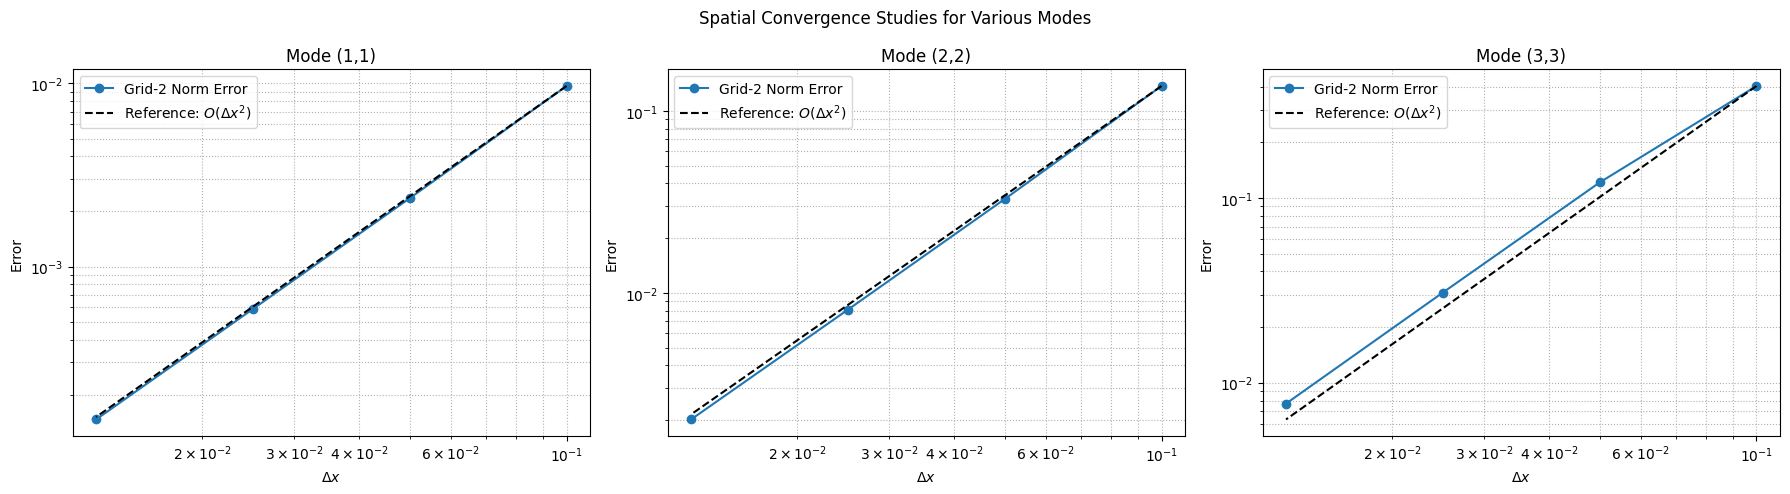

In [ ]:
errors_1 = spatial_convergence_study(m=1, n=1, T=2.0)
errors_2 = spatial_convergence_study(m=2, n=2, T=2.0)
errors_3 = spatial_convergence_study(m=3, n=3, T=2.0)

dx_vals = [1.0 / 10, 1.0 / 20, 1.0 / 40, 1.0 / 80]
mode_list = [(1, 1), (2, 2), (3, 3)]
errors_list = [errors_1, errors_2, errors_3]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (errors, (m, n)) in enumerate(zip(errors_list, mode_list)):
    ax = axes[i]
    ax.loglog(dx_vals, errors, 'o-', label='Grid-2 Norm Error')

    # Reference line with O(dx^2)
    ref = errors[0] * (np.array(dx_vals) / dx_vals[0])**2
    ax.loglog(dx_vals, ref, 'k--', label='Reference: $O(\\Delta x^2)$')

    ax.set_xlabel('$\\Delta x$')
    ax.set_ylabel('Error')
    ax.set_title(f'Mode ({m},{n})')
    ax.grid(True, which='both', ls=':')
    ax.legend()

plt.suptitle('Spatial Convergence Studies for Various Modes')
plt.tight_layout()
plt.show()

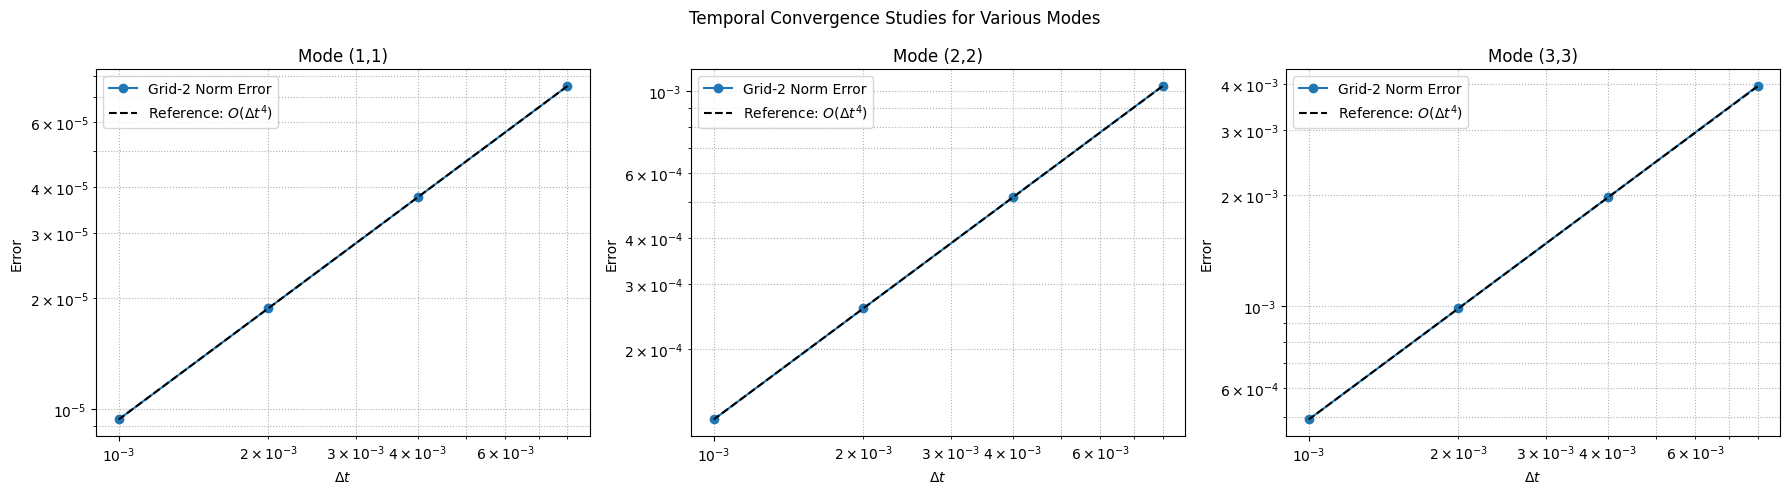

In [ ]:
errors_1 = temporal_convergence_study(m=1, n=1, T=2.0)
errors_2 = temporal_convergence_study(m=2, n=2, T=2.0)
errors_3 = temporal_convergence_study(m=3, n=3, T=2.0)

dt_list = [0.008, 0.004, 0.002, 0.001]
mode_list = [(1, 1), (2, 2), (3, 3)]
errors_list = [errors_1, errors_2, errors_3]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (errors, (m, n)) in enumerate(zip(errors_list, mode_list)):
    ax = axes[i]
    ax.loglog(dt_list, errors, 'o-', label='Grid-2 Norm Error')

    # Reference line with O(dt^4)
    ref = errors[-1] * (np.array(dt_list) / dt_list[-1])
    ax.loglog(dt_list, ref, 'k--', label='Reference: $O(\\Delta t^4)$')

    ax.set_xlabel('$\\Delta t$')
    ax.set_ylabel('Error')
    ax.set_title(f'Mode ({m},{n})')
    ax.grid(True, which='both', ls=':')
    ax.legend()

plt.suptitle('Temporal Convergence Studies for Various Modes')
plt.tight_layout()
plt.show()

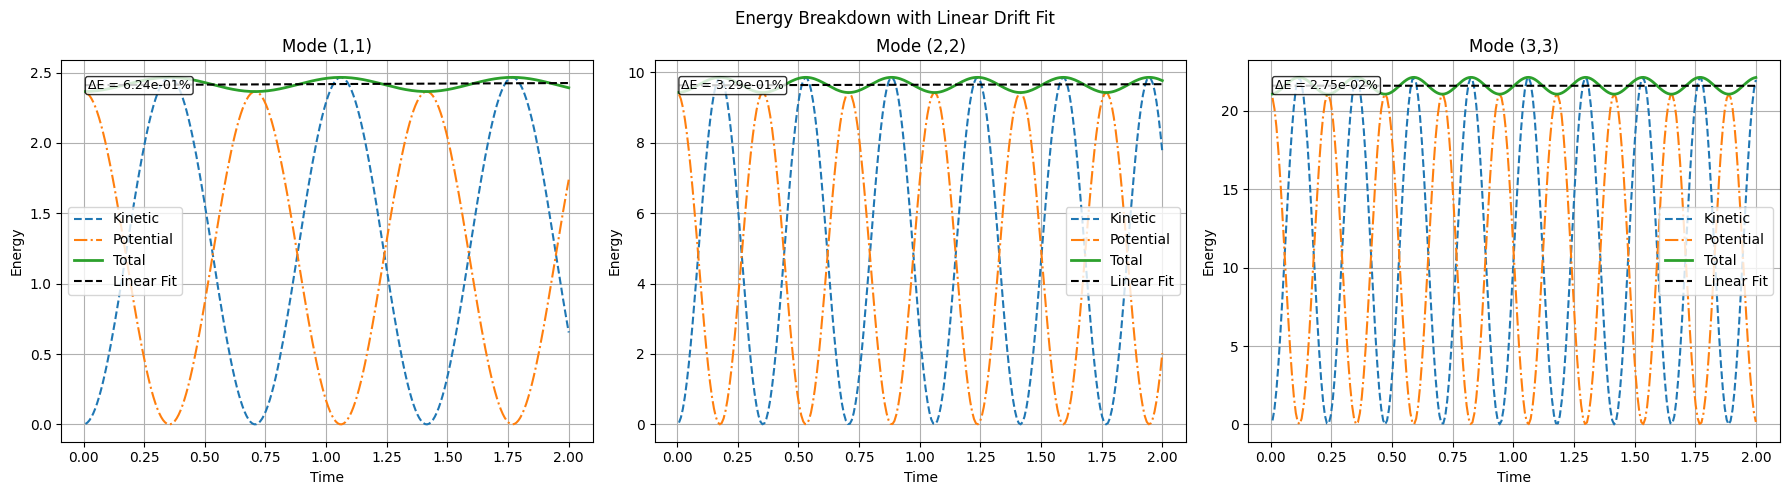

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Independent y-axes

mode_data = [
    (times1, ke1, pe1, te1, (1, 1)),
    (times2, ke2, pe2, te2, (2, 2)),
    (times3, ke3, pe3, te3, (3, 3))
]

for ax, (times, ke, pe, te, (m, n)) in zip(axes, mode_data):
    times = np.array(times)
    te = np.array(te)

    # Polynomial fit (linear)
    coeffs = np.polyfit(times, te, 1)
    poly = np.poly1d(coeffs)
    te_fit = poly(times)

    # Plot energies
    ax.plot(times, ke, '--', label='Kinetic')
    ax.plot(times, pe, '-.', label='Potential')
    ax.plot(times, te, label='Total', linewidth=2)
    ax.plot(times, te_fit, 'k--', label='Linear Fit')

    # Plot drift as a % annotation
    delta = te_fit[-1] - te_fit[0]
    percent = 100 * abs(delta) / te_fit[0]
    ax.text(0.05, 0.95, f"ΔE = {percent:.2e}%", transform=ax.transAxes,
            ha='left', va='top', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='black', alpha=0.8))

    ax.set_title(f'Mode ({m},{n})')
    ax.set_xlabel('Time')
    ax.set_ylabel('Energy')
    ax.grid(True)
    ax.legend()

fig.suptitle('Energy Breakdown with Linear Drift Fit')
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()


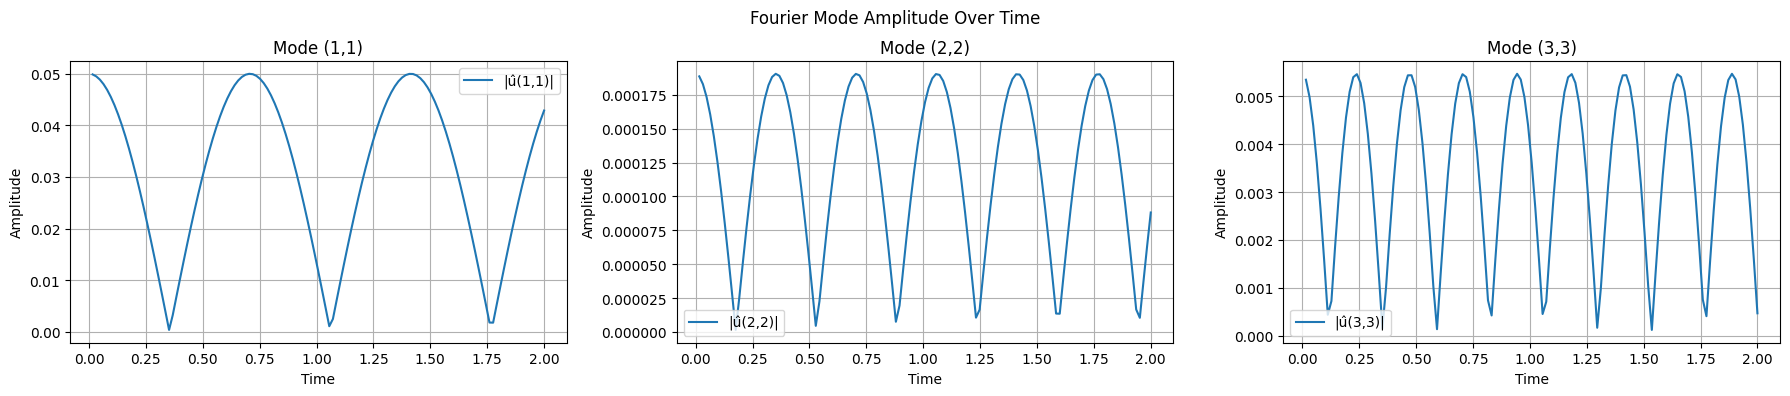

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

mode_data = [
    (fft_t1, amps1, (1, 1)),
    (fft_t2, amps2, (2, 2)),
    (fft_t3, amps3, (3, 3))
]

for ax, (times, amps, (m, n)) in zip(axes, mode_data):
    ax.plot(times, amps, label=f'|û({m},{n})|')
    ax.set_title(f'Mode ({m},{n})')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.grid(True)
    ax.legend()

fig.suptitle('Fourier Mode Amplitude Over Time')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()
